In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", font_scale=1)

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
  mean_absolute_error,
  mean_squared_error,
  mean_absolute_percentage_error,
  accuracy_score,
  f1_score
)

from sklearn.utils import resample

import random

In [8]:
n_classes = 10

X, y = load_digits(n_class=n_classes, return_X_y=True)
to_sample = False

In [9]:
# X, y = sampled[:, :-1], np.array(sampled[:, -1], dtype=np.int32)
X.shape, y.shape, np.unique(y)

((1797, 64), (1797,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

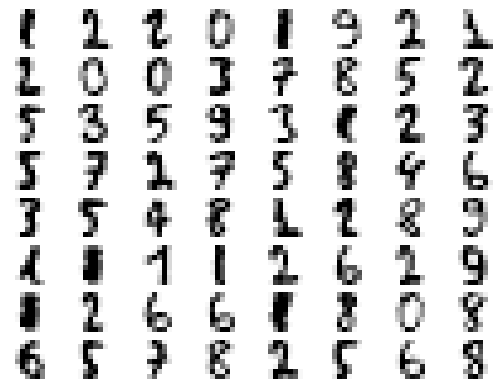

In [10]:
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plt.imshow(X[random.randint(0, X.shape[0])].reshape(8, 8), cmap='Greys')

In [11]:
X.shape, y.shape

((1797, 64), (1797,))

In [12]:
n_features = X.shape[1]
n_targets = n_classes

In [13]:
%load_ext autoreload
%autoreload

In [14]:
from common.distributor import UniformDataDistributor, DataDistributor
from optimization.federative.fedavg import FederatedAveraging, Model
from optimization.federative.scaffold import Scaffold
from optimization.federative.fedprox import FedProx
from optimization.federative.scaffnew import Scaffnew

/Users/locllos/anaconda3/envs/DS-3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-05 22:19:48,437	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [15]:
from function.vanilla import MSERidgeLinear, MSELassoLinear
from function.torch import TorchFunction

In [16]:
import torch

In [17]:
torch_model = torch.nn.Sequential(
  torch.nn.Linear(n_features, 32),
  torch.nn.Sigmoid(),
  torch.nn.Linear(32, n_targets),
  torch.nn.Softmax(dim=-1)
)
function = TorchFunction(torch_model, torch.nn.CrossEntropyLoss())

torch_enable = True

In [18]:
distributor = DataDistributor(test_size=0.2, server_fraction=0.2)

In [19]:
from pipeline.pipeline import Pipeline

In [20]:
from common.reducers import mean, max, min

In [21]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
threadpool = None


Scaffold for parameters: {'n_clients': 32, 'iid_fraction': 0.1, 'clients_fraction': 0.4, 'batch_size': 256, 'epochs': 512, 'rounds': 24, 'eta': 0.5}:


learning: 100%|██████████| 24/24 [00:11<00:00,  2.11it/s]


f1_score : 0.9300674815380697

Scaffnew for parameters: {'n_clients': 32, 'iid_fraction': 0, 'clients_fraction': 1, 'batch_size': 256, 'epochs': 256, 'rounds': 24, 'eta': 0.5, 'proba': 0.01}:


learning: 100%|██████████| 24/24 [00:12<00:00,  1.88it/s]


f1_score : 0.972089947089947
done


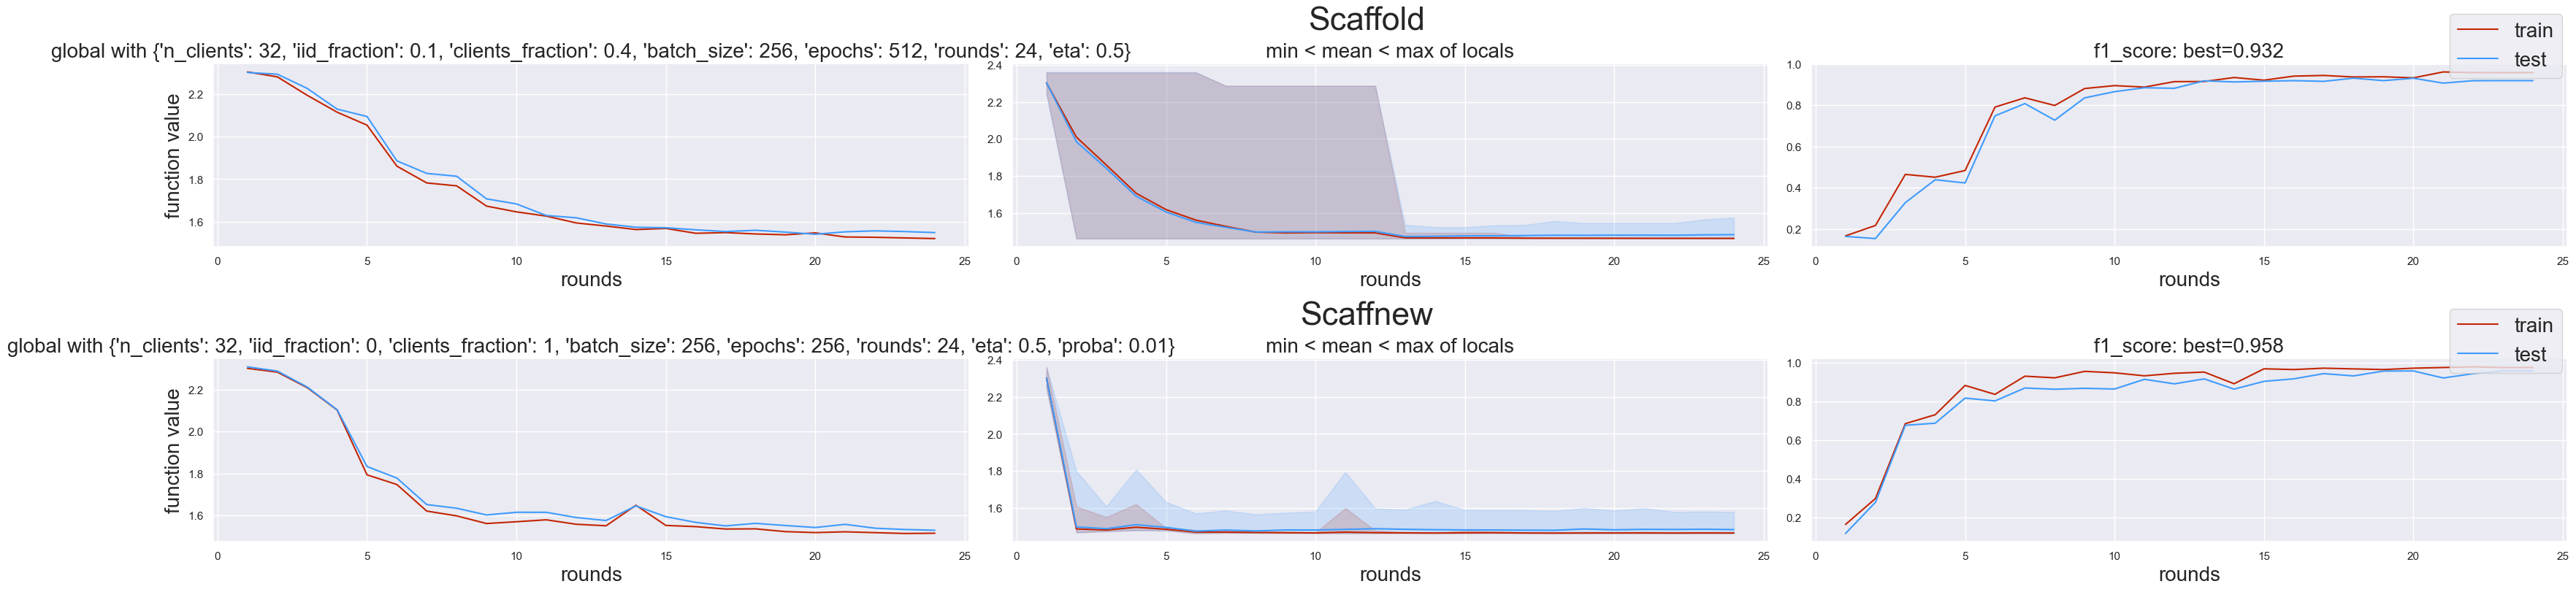

In [23]:
optimizer_parameters = {
  "Scaffold" : {
    "n_clients" : [32],
    "iid_fraction" : [0.1],
    "clients_fraction": [0.4],
    "batch_size": [256], 
    "epochs": [512], # 16, 64, 
    "rounds": [24],
    "eta": [50e-2], # , 1e-2
  },
  "Scaffnew" : {
    "n_clients" : [32],
    "iid_fraction" : [0],
    "clients_fraction": [1],
    "batch_size": [256], 
    "epochs": [256], # 16, 64, 
    "rounds": [24],
    "eta": [50e-2], # , 1e-2
    "proba" : [0.01]
  }
}
metrics = {
  "f1_score" : lambda y_proba, y_true: f1_score(np.argmax(y_proba, axis=1), y_true, average="weighted")
}

pipeline = Pipeline(
  function=function,
  optimizers=[Scaffold, Scaffnew],
  metrics=metrics,
  optimizer_parameters=optimizer_parameters,
  distributor=distributor,
  X=X,
  y=y,
  executor=threadpool
)

best, best_params = pipeline.run(
  choose_best_by="accuracy",
  scaled=False, 
  reducers=[]
)

print("done")

In [113]:
best_params

{'clients_fraction': 0.3, 'batch_size': 64, 'epochs': 128, 'eta': 0.001}

  MSE: 18028.008939559943
  MAE: 107.54545703886623
  MAPE: 2.56955305725453


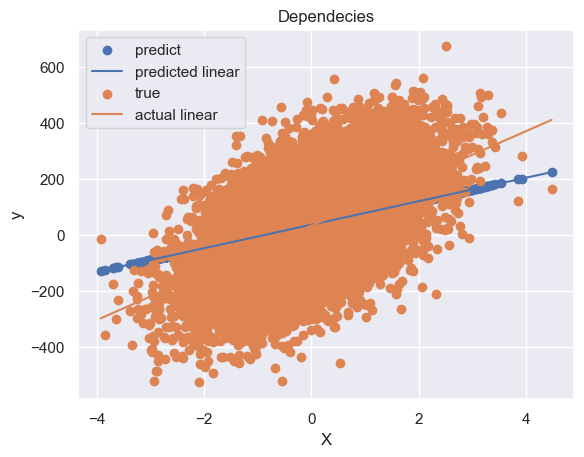

In [115]:
if n_features == 1 and n_targets == 1:
  draw_linear(
    X, y, np.array([*coeff_actual, bias_actual]),
    best.server.function.predict(X), best.server.function.weights()
  )
print(f"\
  MSE: {mean_squared_error(y, best.server.function.predict(X))}\n\
  MAE: {mean_absolute_error(y, best.server.function.predict(X))}\n\
  MAPE: {mean_absolute_percentage_error(y, best.server.function.predict(X))}\
")

In [ ]:
import torch

In [ ]:
torch.vstack((torch.Tensor([1]), torch.Tensor([1])))

tensor([[1.],
        [1.]])

In [ ]:
a = torch.arange(1, 4 * 5 + 1)
b = torch.arange(1, 4 * 1 + 1)
a, b

(tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20]),
 tensor([1, 2, 3, 4]))

In [ ]:
torch.cat((a, b)).shape

torch.Size([24])

In [ ]:
a[[[1, 2, 3], [2, 2, 2]]]

tensor([ 8, 13, 18])

In [230]:
def _by_norm2(data: np.ndarray):
  return np.linalg.norm(data, ord=2, axis=1)

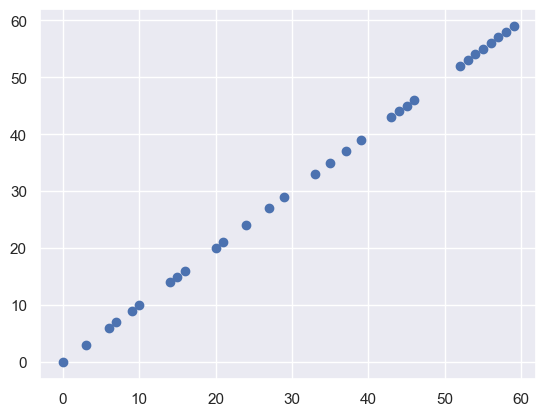

In [231]:
iid_fraction = 0.5
n_samples = 60

def _iid_size(total: int):
  return int(iid_fraction * total)

X = np.arange(0, n_samples).reshape((n_samples, 1))
y = np.arange(0, n_samples).reshape((n_samples, 1))

indices = np.arange(0, n_samples)
np.random.shuffle(indices)

iid = indices[:_iid_size(len(indices))]
X_iid = X[iid]
y_iid = y[iid]

plt.scatter(X_iid, y_iid)

In [232]:
non_iid = indices[_iid_size(len(indices)):]

y_non_iid = y[non_iid]
X_non_iid = X[non_iid]
sorted_non_iid = np.argsort(_by_norm2(y_non_iid))

y_non_iid = y_non_iid[sorted_non_iid]
X_non_iid = X_non_iid[sorted_non_iid]

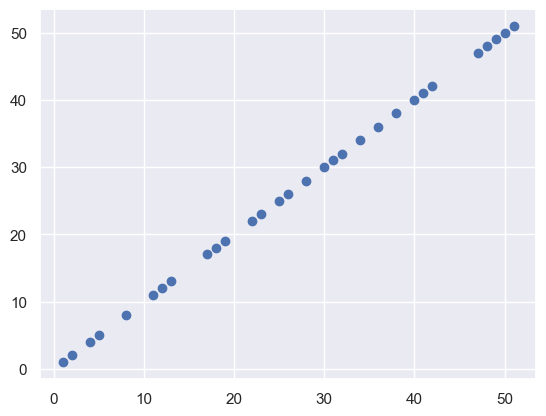

In [233]:
X_non_iid = X[non_iid]
y_non_iid = y[non_iid]
plt.scatter(X_non_iid, y_non_iid)

In [234]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [287]:
from common.distributor import (
  DataDistributor
)
from optimization.federative.fedavg import FederatedAveraging
from optimization.federative.scaffold import Scaffold

In [323]:
y.shape

(8192, 1)

In [324]:
distrotest = DataDistributor()
data = distrotest.distribute(
  X=X,
  y=y,
  n_parts=10,
  iid_fraction=0,
  test_size=0.2
)

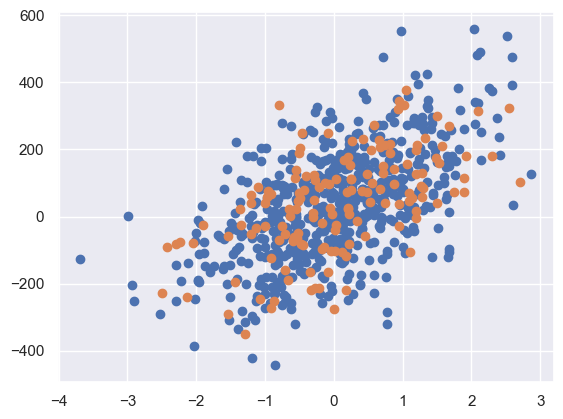

In [335]:
plt.scatter(data["train"]["X"]["server"], data["train"]["y"]["server"])
plt.scatter(data["test"]["X"]["server"], data["test"]["y"]["server"])

In [326]:
data["train"]["X"]["clients"][0].shape

(596, 1)

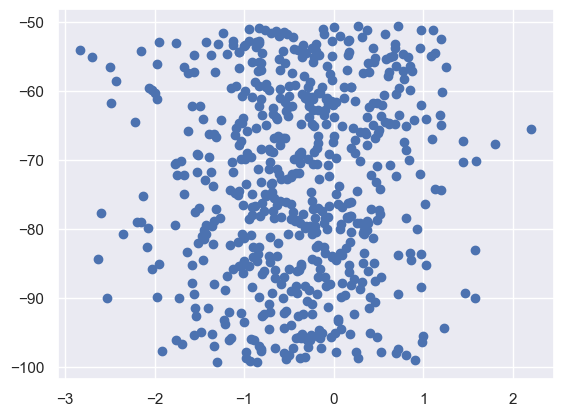

In [329]:
plt.scatter(data["train"]["X"]["clients"][2], data["train"]["y"]["clients"][2])

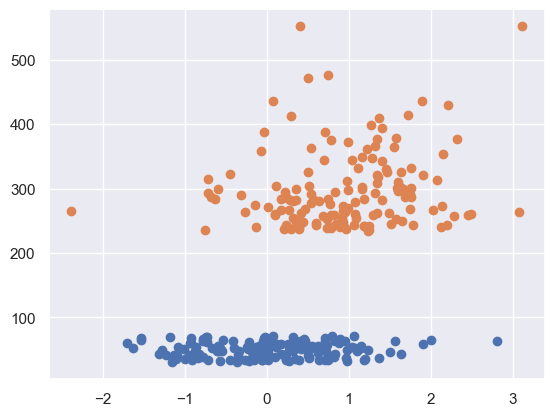

In [336]:
k = 0
for x, y in zip(data["test"]["X"]["clients"], data["test"]["y"]["clients"]):
  if k == 5 or k == 9:
    plt.scatter(x, y)
  k += 1
# k = 0
# for x, y in zip(data["test"]["X"]["clients"], data["test"]["y"]["clients"]):
#   if k == 1 or k == 3:
#     plt.scatter(x, y)
#   k += 1


In [26]:
y = np.linspace(0, 20, 100)
tensor = torch.tensor(y)
tensor.type()

'torch.DoubleTensor'